In [1]:
import hyppo
from hyppo.discrim._utils import _CheckInputs
from hyppo.independence import Dcorr
from dask.distributed import Client, progress
import dask.dataframe as ddf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

In [2]:
from twosample import *
from simhelper import *
from twosample_sims import *

In [3]:
X1, X2, y, z = noeff_twosample(50, 2, 2, 2)

ratio1 = statistic(X1, y, z)[2]
ratio2 = statistic(X2, y, z)[2]
dcor1 = dcorr_statistic(X1, z); dcor2 = dcorr_statistic(X2, z)
manova1 = manova_statistic(X1, y, z); manova2 = manova_statistic(X2, y, z)
print("Ratio 1: {:3f}, Ratio 2: {:3f}".format(ratio1, ratio2))
print("Dcor 1: {:3f}, Dcor 2: {:3f}".format(dcor1, dcor2))
print("Manova 1: {:3f}, Manova 2: {:3f}".format(manova1, manova2))

Ratio 1: 1.000907, Ratio 2: 1.001369
Dcor 1: 0.020164, Dcor 2: 0.014637
Manova 1: 0.974521, Manova 2: 0.956730


<AxesSubplot:xlabel='x1', ylabel='x2'>

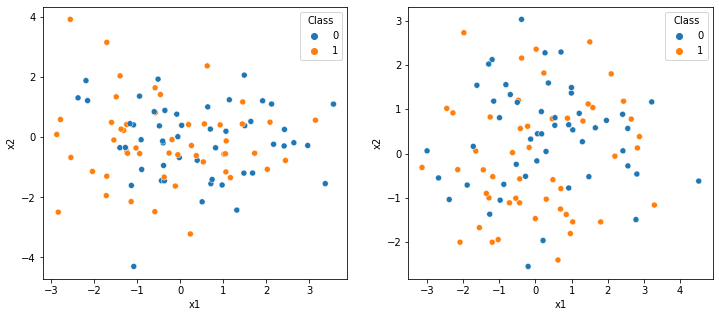

In [4]:
Xdat1 = pd.DataFrame({"x1": X1[:,0],  "x2": X1[:, 1], "Class": z, "individual": y})
Xdat2 = pd.DataFrame({"x1": X2[:,0],  "x2": X2[:, 1], "Class": z, "individual": y})
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x="x1", y="x2", data=Xdat1, ax=axs[0], hue="Class")
sns.scatterplot(x="x1", y="x2", data=Xdat2, ax=axs[1], hue="Class")

In [5]:
X1, X2, y, z = gaussian_twosample(50, 2, 2, 2)

ratio1 = statistic(X1, y, z)[2]
ratio2 = statistic(X2, y, z)[2]
dcor1 = dcorr_statistic(X1, z); dcor2 = dcorr_statistic(X2, z)
manova1 = manova_statistic(X1, y, z); manova2 = manova_statistic(X2, y, z)
print("Ratio 1: {:3f}, Ratio 2: {:3f}".format(ratio1, ratio2))
print("Dcor 1: {:3f}, Dcor 2: {:3f}".format(dcor1, dcor2))
print("Manova 1: {:3f}, Manova 2: {:3f}".format(manova1, manova2))

Ratio 1: 1.072052, Ratio 2: 1.101080
Dcor 1: 0.284685, Dcor 2: 0.480096
Manova 1: 0.609765, Manova 2: 0.423150


<AxesSubplot:xlabel='x1', ylabel='x2'>

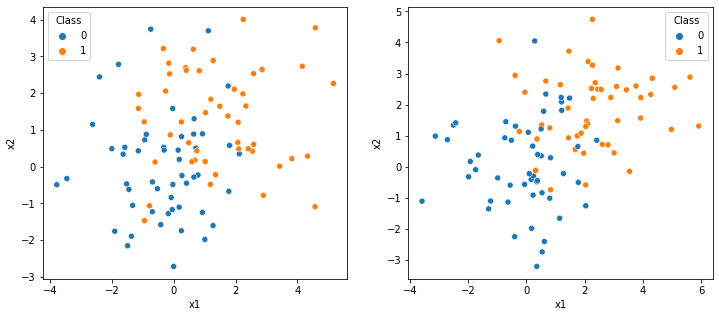

In [6]:
Xdat1 = pd.DataFrame({"x1": X1[:,0],  "x2": X1[:, 1], "Class": z, "individual": y})
Xdat2 = pd.DataFrame({"x1": X2[:,0],  "x2": X2[:, 1], "Class": z, "individual": y})
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x="x1", y="x2", data=Xdat1, ax=axs[0], hue="Class")
sns.scatterplot(x="x1", y="x2", data=Xdat2, ax=axs[1], hue="Class")

In [7]:
X1, X2, y, z = ballcirc_twosample(50, 2, 2, 2)

ratio1 = statistic(X1, y, z)[2]
ratio2 = statistic(X2, y, z)[2]
dcor1 = dcorr_statistic(X1, z); dcor2 = dcorr_statistic(X2, z)
manova1 = manova_statistic(X1, y, z); manova2 = manova_statistic(X2, y, z)
print("Ratio 1: {:3f}, Ratio 2: {:3f}".format(ratio1, ratio2))
print("Dcor 1: {:3f}, Dcor 2: {:3f}".format(dcor1, dcor2))
print("Manova 1: {:3f}, Manova 2: {:3f}".format(manova1, manova2))

Ratio 1: 1.024965, Ratio 2: 1.071755
Dcor 1: 0.036401, Dcor 2: 0.200944
Manova 1: 0.970232, Manova 2: 0.920102


<AxesSubplot:xlabel='x1', ylabel='x2'>

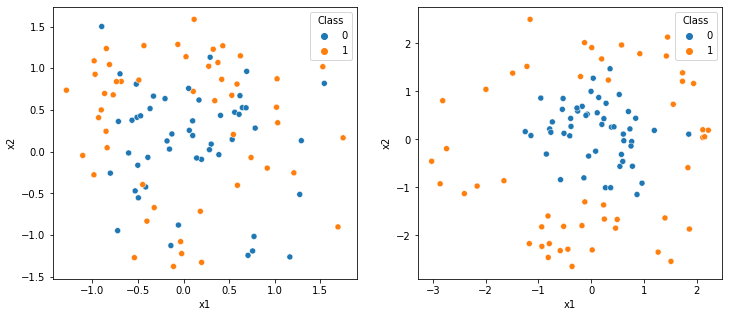

In [8]:
Xdat1 = pd.DataFrame({"x1": X1[:,0],  "x2": X1[:, 1], "Class": z, "individual": y})
Xdat2 = pd.DataFrame({"x1": X2[:,0],  "x2": X2[:, 1], "Class": z, "individual": y})
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x="x1", y="x2", data=Xdat1, ax=axs[0], hue="Class")
sns.scatterplot(x="x1", y="x2", data=Xdat2, ax=axs[1], hue="Class")

In [9]:
ncores = 10
client = Client(threads_per_worker=1, n_workers=ncores)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54907,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:54965,Total threads: 1
Dashboard: http://127.0.0.1:54968/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:54917,


In [10]:
outer_reps = 100
pvalues = []
Nsubs = []
Nbreaks = 6
T = 3
ndim = 2
reps = 1000

def run_exp_t2st(row):
    if row[0] == "Gaussian":
        X1, X2, y, z = gaussian_twosample(int(row[1]), T, ndim, 2)
    if row[0] == "No Effect":
        X1, X2, y, z = noeff_twosample(int(row[1]), T, ndim, 2)
    if row[0] == "Circle/Disc":
        X1, X2, y, z = ballcirc_twosample(int(row[1]), T, ndim, 2)
    pvalue_cdiscr, pvalue_dcorr, pvalue_manova = two_sample_test(X1, X2, y, z, reps=reps)
    return (row[0], row[1], row[2], pvalue_cdiscr, pvalue_manova, pvalue_dcorr)

exps = []
for exp_type in ["No Effect", "Gaussian", "Circle/Disc"]:
    for Nsub in np.floor(2**np.linspace(4, 7, num=Nbreaks)):
        for i in range(outer_reps):
            exps.append([exp_type, int(Nsub), i])

sim_exps = pd.DataFrame(exps, columns=["Simulation", "NSubs", "ID"])
print(sim_exps.head())
print(sim_exps.shape)

  Simulation  NSubs  ID
0  No Effect     16   0
1  No Effect     16   1
2  No Effect     16   2
3  No Effect     16   3
4  No Effect     16   4
(1800, 3)


In [11]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=int(ncores*1.5))
sim_results = sim_exps.apply(lambda x: run_exp_tst(x), axis=1, result_type="expand",
                            meta={0: object, 1: int, 2: int, 3: float, 4: float, 5: float})
sim_results

,0,1,2,3,4,5
npartitions=15,,,,,,
0,object,int64,int64,float64,float64,float64
120,...,...,...,...,...,...
...,...,...,...,...,...,...
1680,...,...,...,...,...,...
1799,...,...,...,...,...,...


In [ ]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Simulation", 1: "NSubs", 2: "index", 3: "pvalue_cdiscr",
                                          4: "pvalue_manova", 5: "pvalue_dcorr"})
sim_results.to_csv('./data/sims_twosample.csv')

/Users/eric/.virtualenvs/graph-book/lib/python3.8/site-packages/dask/base.py:1363: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


In [ ]:
sim_results

In [ ]:
sim_results = pd.read_csv('./data/sims_twosample.csv')
long_results = pd.wide_to_long(sim_results, stubnames="pvalue", i=["Simulation", "NSubs", "index"],
                               j="Statistic", sep="_", suffix='\\w+')

In [ ]:
alpha = .05
long_results["Outcome"] = long_results["pvalue"] < alpha
long_results_power = long_results.groupby(["Simulation", "NSubs", "Statistic"]).agg({"Outcome": np.mean}).reset_index()

In [ ]:
g = sns.FacetGrid(long_results_power, col="Simulation", hue="Statistic")
g.map(sns.lineplot, "NSubs", "Outcome")
g.add_legend();